In [118]:
# ---------------------------------------------------------
# EDA 
# ---------------------------------------------------------
# Imports 
import json  
import zipfile  

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split



%matplotlib inline 


# That Data
df = pd.read_json('../data.json')
# df.head()

# Make fraud column 
df['fraud'] = df.acct_type.apply(lambda x: 1 if 'fraud' in x else 0)
df['fraud'] = (df['acct_type'] == 'fraud').astype(int)
# Get columns 
columns = list(df.columns)

# See What they looks like 
# df.info()

# Get missing varaiabels 
missing_values = []
for col in columns:
    if df[col].isna().any():
        missing_values.append(col)
        
print(f'Number: {len(missing_values)} \n\nVariables with missing values:\n{missing_values}')

# get variabels by type 
var_floats = []
var_ints = []
var_objects = []

for col in columns:
    if df[col].dtype == 'int64':
        var_ints.append(col)
    elif df[col].dtype == 'float64':
        var_floats.append(col)
    else:
        var_objects.append(col)

print(f' Floats: {var_floats} \n\n Ints: {var_ints} \n\n Objects: {var_objects}')

Number: 12 

Variables with missing values:
['country', 'delivery_method', 'event_published', 'has_header', 'org_facebook', 'org_twitter', 'sale_duration', 'venue_country', 'venue_latitude', 'venue_longitude', 'venue_name', 'venue_state']
 Floats: ['delivery_method', 'event_published', 'gts', 'has_header', 'org_facebook', 'org_twitter', 'sale_duration', 'venue_latitude', 'venue_longitude'] 

 Ints: ['approx_payout_date', 'body_length', 'channels', 'event_created', 'event_end', 'event_start', 'fb_published', 'has_analytics', 'has_logo', 'name_length', 'num_order', 'num_payouts', 'object_id', 'sale_duration2', 'show_map', 'user_age', 'user_created', 'user_type', 'fraud'] 

 Objects: ['acct_type', 'country', 'currency', 'description', 'email_domain', 'listed', 'name', 'org_desc', 'org_name', 'payee_name', 'payout_type', 'previous_payouts', 'ticket_types', 'venue_address', 'venue_country', 'venue_name', 'venue_state']


In [119]:
# X is features, y is target. Returns a cross tab of predicted 
# and actual values for fraud vs not fraud
def get_crosstab(X, y, model_type):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
    model = model_type
    model.fit(Xtrain, ytrain)
    predicted = model.predict(Xtest)
    actual = ytest
    crosstab = pd.crosstab(ytest, model.predict(Xtest), rownames=['actual'], colnames=['predicted'])
    return model, crosstab

In [53]:
# Use the features previous payout and user age to make 
# the FIRST MODEL, a logistic regression model
import pickle
from sklearn.linear_model import LogisticRegression

mask = df.previous_payouts.apply(lambda x: 0 if len(x) <= 0 else 1)
# df['previous_payouts'].isnotnull().astype(int)
df['mask_previous_payout'] = mask
X = df[['mask_previous_payout', 'user_age']]
y = df['fraud'].apply(lambda x: 'Fraud' if x == 1 else 'Not')

model, crosstab = get_crosstab(X, y, LogisticRegression())
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
crosstab
# model_path = './models/model.pickle'
# pickle.dump(model, open(model_path, 'wb'))

predicted,Fraud,Not
actual,,
Fraud,237,70
Not,24,3254


In [120]:
def not_premium(x):
    return 1 if x.lower() != 'premium' else 0

def no_previous_payout(x):
    return 1 if len(x) <= 0 else 0

def payout_name_flag(x):
    for d in x:
        if len(d['name']) > 3:
            return 1
    return 0

def payout_toself(payee, payouts):
    for pay in payouts:
        if payee.lower() in pay['name'].lower():
            return 1
    return 0

# ---------------------------------------------------------------------------
# End Funtions 
# ---------------------------------------------------------------------------
# 
temp = dict()
temp = {'target': df['fraud'].copy(), 
        'previous_payout': df.previous_payouts.apply(lambda x: no_previous_payout(x)),
#         'premium': df.acct_type.apply(lambda x: not_premium(x)),
        'no_payout_name': df.previous_payouts.apply(lambda x: payout_name_flag(x)),
        'payout_toself': df.apply(lambda x: payout_toself(x.payee_name, x.previous_payouts), axis = 1),
        'account_type' : df['user_type'],
        'delivery_method' : df['delivery_method']
       }


df_model = pd.DataFrame(temp)
# we filled nan values with 0 because more fradulent users 
# had missing values, and most fradulant users 
# have a delivery method of 0
df_model['delivery_method'] = df['delivery_method'].fillna(0)
# venue name 

In [121]:
X = df_model.drop('target', axis = 1)
X['user_age'] = df['user_age']
y = df_model['target']
y = y.apply(lambda x: 'Fraud' if x == 1 else 'Not')

X.columns


Index(['previous_payout', 'no_payout_name', 'payout_toself', 'account_type',
       'delivery_method', 'user_age'],
      dtype='object')

In [122]:
from sklearn.tree import DecisionTreeClassifier
model, crosstab = get_crosstab(X, y, DecisionTreeClassifier())
crosstab

predicted,Fraud,Not
actual,,
Fraud,257,67
Not,42,3219


In [123]:
# make predictions with a given model, setting the threshold to 
# a probability of you choice between (0, 1)
def predict(model, X, threshold=0.5):
    '''Return prediction of the fitted binary-classifier model model on X using
    the specifed `threshold`. NB: class 0 is the positive class'''
    return np.where(model.predict_proba(X)[:, 0] > threshold,
                    model.classes_[0],
                    model.classes_[1])

# create confusion matrix with a given model and Xtest
def confusion_matrix(model, X, threshold=0.5):
    cf = pd.crosstab(ytest, predict(model, Xtest, threshold), dropna=False)
    cf = cf.add(pd.DataFrame([[0,0],[0,0]], columns=['Fraud', 'Not'], index=['Fraud', 'Not']), fill_value=0)
    cf.index.name = 'actual'
    cf.columns.name = 'predicted'
    return cf

# calculate the payout for a given probability threshold
def calculate_payout(cb_matrix, model, X, threshold):
    return (confusion_matrix(model, X, threshold) * cb_matrix).values.sum()



In [128]:
import numpy as np


def profit_curve(model, X):
    cb_matrix = pd.DataFrame([[0, -20], [-5, 0]], columns=["Fraud", "Not"], index=["Fraud", "Not"])
    cb_matrix.index.name = 'actual'
    cb_matrix.columns.name = 'predicted'
    # calculate the payout with a the cost benefit matrix, 
    # given threshhold, model, and X
    thresholds = np.arange(0.0, 1.0, 0.01)
    profits = []
    for threshold in thresholds:
        profits.append(calculate_payout(cb_matrix, model, X, threshold))
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(thresholds, profits)
    ax.set_xlabel('Thresholds')
    ax.set_ylabel('Profits')
    ax.set_title('Profit Curve')



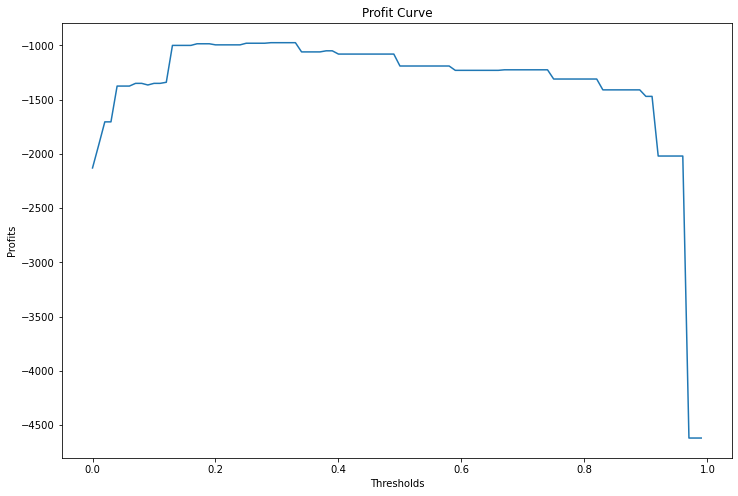

In [129]:
profit_curve(model, X)

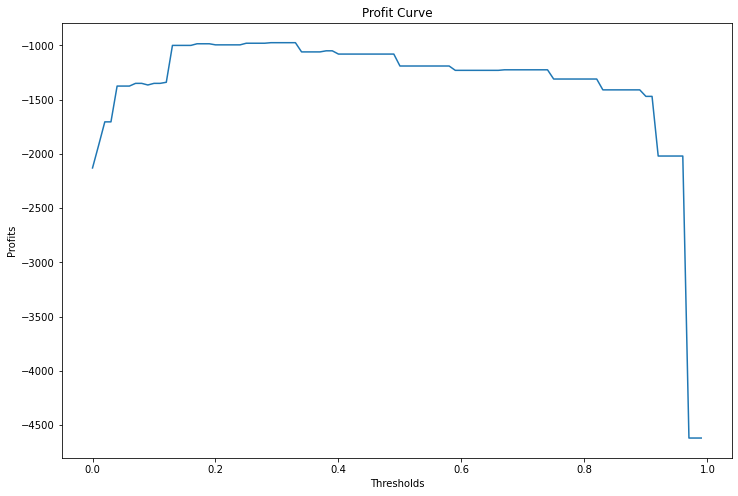

In [130]:
profit_curve(model, X)

In [117]:
import numpy as np
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
model.predict_proba(Xtest)


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [116]:
get_crosstab(X, y, LogisticRegression())

[[0.97267806 0.02732194]
 [0.97267806 0.02732194]
 [0.97267806 0.02732194]
 ...
 [0.97267806 0.02732194]
 [0.97267806 0.02732194]
 [0.98878235 0.01121765]]


(LogisticRegression(),
 predicted     0    1
 actual              
 0          3235   14
 1            75  261)

In [112]:
# Fraud	248	70
# Not	24	3243
y.value_counts()


Not      13044
Fraud     1293
Name: fraud, dtype: int64

In [133]:
# is the users country the same as the one the event is in if their 
# a new user 
get_crosstab(X, y, LogisticRegression())

[[0.99484618 0.00515382]
 [0.9575325  0.0424675 ]
 [0.98869129 0.01130871]
 ...
 [0.96787737 0.03212263]
 [0.07764601 0.92235399]
 [0.97735809 0.02264191]]


(LogisticRegression(),
 predicted     0    1
 actual              
 0          3242   26
 1            71  246)

In [137]:

get_crosstab(X, y, LogisticRegression())
X.columns

[[9.99529266e-01 4.70733559e-04]
 [9.98701231e-01 1.29876945e-03]
 [9.98715810e-01 1.28419009e-03]
 ...
 [7.03066617e-01 2.96933383e-01]
 [9.99272197e-01 7.27803397e-04]
 [9.98719945e-01 1.28005466e-03]]


Index(['previous_payout', 'premium', 'no_payout_name', 'payout_toself',
       'user_age'],
      dtype='object')

In [89]:
import numpy as np
cb_matrix = pd.DataFrame([[0, -20], [-5, 0]], columns=["Fraud", "Not"], index=["Fraud", "Not"])
cb_matrix.index.name = 'actual'
cb_matrix.columns.name = 'predicted'
cb_matrix

def calculate_payout(cb_matrix, model, X, threshold):
    return (confusion_matrix(model, X, threshold) * cb_matrix).values.sum()
    thresholds = np.arange(0.0, 1.0, 0.01)
    profits = []
    for threshold in thresholds:
        profits.append(calculate_payout(cb_matrix, model, X, threshold))
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(thresholds, profits)
    ax.set_xlabel('Thresholds')
    ax.set_ylabel('Profits')
    ax.set_title('Profit Curve')

In [79]:
from sklearn.ensemble import RandomForestClassifier
get_crosstab(X, y, RandomForestClassifier())

(RandomForestClassifier(),
 predicted  Fraud   Not
 actual                
 Fraud        251    75
 Not           29  3230)

In [141]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
model = RandomForestClassifier()
model.fit(Xtrain, ytrain)
predicted = model.predict(Xtest)
actual = ytest
predicted
    

array([0, 0, 0, ..., 1, 0, 0])

In [172]:
# grid search with random forest classifier
from sklearn.ensemble import RandomForestClassifier
get_crosstab(X, y, RandomForestClassifier())

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


(RandomForestClassifier(),
 predicted     0    1
 actual              
 0          3215   40
 1            63  267)

In [6]:
# import pickle
# from sklearn.linear_model import LogisticRegression

# mask = df.previous_payouts.apply(lambda x: 0 if len(x) <= 0 else 1)
# df['mask_previous_payout'] = mask
# X = df[['mask_previous_payout', 'user_age']]
# y = df['fraud'].apply(lambda x: 'Fraud' if x == 1 else 'Not')
# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
# model = LogisticRegression()
# model.fit(Xtrain, ytrain)
# # predicted = model.predict(Xtest)
# ytest

2338     Not
8007     Not
4286     Not
8986     Not
6469     Not
        ... 
6418     Not
11612    Not
2762     Not
11720    Not
5765     Not
Name: fraud, Length: 3585, dtype: object

In [131]:
# Input threshholds for low risk of fraud (greater than lowrisk thresh 
# less than medrisk_thresh), medium risk, and high risk and which model
# Returns the number of data points in each category
def grouped_risk(lowrisk_thresh, medrisk_thresh, highrisk_thresh, model):
    probs = model.predict_proba(Xtest)
    bool1 = (probs[:, 0] > lowrisk_thresh) & (probs[:, 0] <= medrisk_thresh) 
    num_low = probs[bool1].shape[0]
    bool2 = (probs[:, 0] > medrisk_thresh) & (probs[:, 0] <= highrisk_thresh) 
    num_med = probs[bool2].shape[0]
    bool3 = (probs[:, 0] > highrisk_thresh) 
    num_high = probs[bool3].shape[0]
    return num_low, num_med, num_high
grouped_risk(0.2, 0.5, 0.8, model)
    

(46, 11, 286)

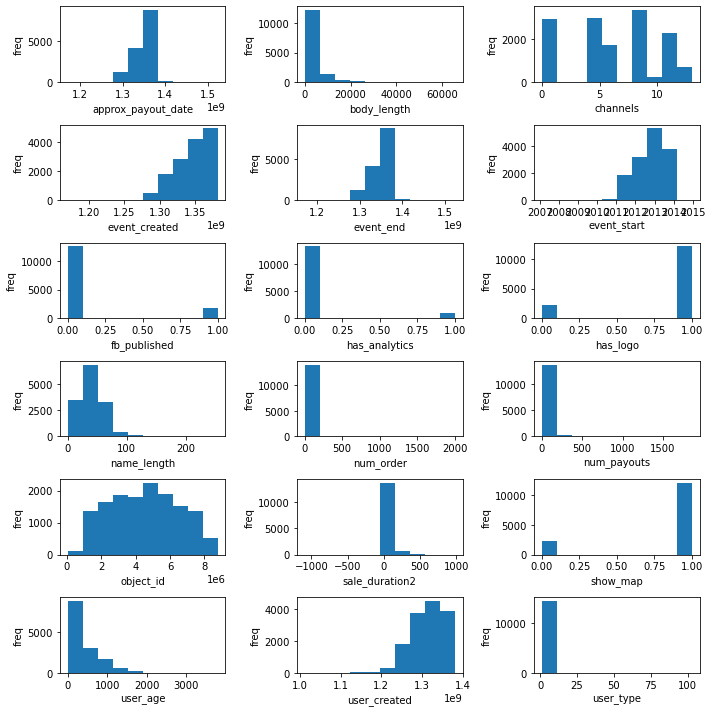

In [54]:
def plot(data, vars_, r, c):
    fig, axs = plt.subplots(r, c, figsize = (10,10))

    for i, ax in enumerate(axs.flatten()):
        ax.hist(data[vars_[i]])
        ax.set_xlabel(vars_[i])
        ax.set_ylabel('freq')

    plt.tight_layout()
plot(df, var_ints, 6, 3)